In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


import pandas as pd
import matplotlib.pyplot as plt
# %matplotlib inline
import numpy as np

## data read


In [2]:


in_f = 10000



data_ST_list = []
for i in range(10):
    cc = np.loadtxt('disease_ST_svd_'+str(i)+'.txt')
    data_ST_list.append(cc)


data_ST_list = np.array(data_ST_list)
data_ST = np.resize(data_ST_list,(3000,10000))

data_ST_ = []
for i in range(data_ST.shape[0]):
    data_ST_.append(data_ST[i][0:in_f])

data_ST_ = np.array(data_ST_)


del data_ST, data_ST_list





data_SB_list = []
for i in range(10):
    cc = np.loadtxt('disease_SB_svd_'+str(i)+'.txt')
    data_SB_list.append(cc)


data_SB_list = np.array(data_SB_list)
data_SB = np.resize(data_SB_list,(5000,10000))

data_SB_ = []
for i in range(data_SB.shape[0]):
    data_SB_.append(data_SB[i][0:in_f])

data_SB_ = np.array(data_SB)


del data_SB, data_SB_list




data_SR_list = []
for i in range(10):
    cc = np.loadtxt('disease_SR_svd_'+str(i)+'.txt')
    data_SR_list.append(cc)


data_SR_list = np.array(data_SR_list)
data_SR = np.resize(data_SR_list,(5000,10000))

data_SR_ = []
for i in range(data_SR.shape[0]):
    data_SR_.append(data_SR[i][0:in_f])

data_SR_ = np.array(data_SR_)


del data_SR, data_SR_list





In [3]:
data_all= np.concatenate((data_SB_,data_SR_,data_ST_),axis=0)

In [4]:
len(data_all[0])


10000

In [5]:
# from sklearn.decomposition import PCA

# pca = PCA(n_components=250)  # reduce to 100 features
# data_all = pca.fit_transform(data_all)

###  old data merge

In [6]:
# data_ST_train = []
# data_SR_train = []
# data_SB_train = []

# for i in range(2500):
#     data_SB_train.append(data_SB_[i])
#     data_SR_train.append(data_SR_[i])
#     data_ST_train.append(data_ST_[i])



# data_ST_test = []
# data_SR_test = []
# data_SB_test = []

# for i in range(3000,4000):
#     data_SB_test.append(data_SB_[i])
#     data_SR_test.append(data_SR_[i])
#     data_ST_test.append(data_ST_[i])


# data_train = data_SB_train + data_SR_train + data_ST_train
# data_test = data_SB_test + data_SR_test + data_ST_test


# del data_SB_train, data_SR_train, data_ST_train
# del data_SB_test, data_SR_test, data_ST_test





In [7]:
# label_train = []
# for i in range(2500):
#     label_train.append(0)

# for i in range(2500):
#     label_train.append(1)

# for i in range(2500):
#     label_train.append(2)

# label_train = np.array(label_train)

# label_test = []
# for i in range(1000):
#     label_test.append(0)

# for i in range(1000):
#     label_test.append(1)

# for i in range(1000):
#     label_test.append(2)

# label_test = np.array(label_test)


### random merge

In [8]:
# list of 5000 0s then 5000 1s then 5000 2s
label = []
for j in range(2):  # 0 for SB, 1 for SR
    for i in range(5000):
        label.append(j)
for i in range(3000):
    label.append(2)  # 2 for ST

In [9]:
len(label)

13000

In [10]:
from sklearn.model_selection import train_test_split
data_train, data_test, label_train, label_test = train_test_split(data_all, label, test_size=0.3, random_state=42)

In [11]:
data_train = torch.FloatTensor(data_train)
label_train = torch.LongTensor(label_train)

data_test = torch.FloatTensor(data_test)
label_test = torch.LongTensor(label_test)

In [12]:
class Model(nn.Module):
  def __init__(self, in_features= 10000 , h1= 2000  , h2= 500,
                h3 = 200 , h4 = 50, h5 = 10,
                    out_features=3):
    super().__init__()
    self.fc1 = nn.Linear(in_features, h1)
    self.fc2 = nn.Linear(h1, h2)
    self.fc3 = nn.Linear(h2, h3)
    self.fc4 = nn.Linear(h3, h4)
    self.fc5 = nn.Linear(h4, h5)


    self.out = nn.Linear(h5, out_features)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))
    x = F.relu(self.fc5(x))


    x = self.out(x)

    return x


torch.manual_seed(42)
model = Model()

def restart():
    torch.manual_seed(42)
    model = Model()
    return model


In [13]:
# accuracy
def accuracy(y_pred, y_test):
  correct = 0
  for i in range(len(y_pred)):
    if y_pred[i] == y_test[i]:
      correct += 1
  return correct / len(y_pred)

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = restart().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

epochs = 251
losses = []
validation_losses = []
test_accuracy = []
train_accuracy = []

# Move data to GPU
data_train = data_train.to(device)
label_train = label_train.to(device)
data_test = data_test.to(device)
label_test = label_test.to(device)

for i in range(epochs):
  
  y_pred = model.forward(data_train) 

  loss = criterion(y_pred, label_train).to("cpu") 
  train_accuracy.append(accuracy(y_pred.argmax(1), label_train))

  # Evaluate Model on Test Data Set (validate model on test set)
  with torch.no_grad():  # Basically turn off back propogation
    y_eval = model.forward(data_test) # X_test are features from our test set, y_eval will be predictions
    validation_loss = criterion(y_eval, label_test).to("cpu") # Find the loss or error
    validation_losses.append(validation_loss.detach().numpy().item())
    test_accuracy.append(accuracy(y_eval.argmax(1), label_test))


  losses.append(loss.detach().numpy().item())

  if i % 25 == 0:
    print(f'Epoch: {i} and train loss: {loss} | validation loss : {validation_loss}')
    acc= accuracy(y_eval.argmax(1), label_test)
    acc_train = accuracy(y_pred.argmax(1), label_train)
    print(f'Epoch: {i} Accuracy Train: {acc_train} | Accuracy Test: {acc}')

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

Epoch: 0 and train loss: 1.0872822999954224 | validation loss : 1.081192135810852
Epoch: 0 Accuracy Train: 0.381978021978022 | Accuracy Test: 0.39076923076923076
Epoch: 25 and train loss: 1.0100711584091187 | validation loss : 1.0197075605392456
Epoch: 25 Accuracy Train: 0.4958241758241758 | Accuracy Test: 0.48
Epoch: 50 and train loss: 0.9114545583724976 | validation loss : 0.9939014911651611
Epoch: 50 Accuracy Train: 0.5385714285714286 | Accuracy Test: 0.5094871794871795
Epoch: 75 and train loss: 0.7952314019203186 | validation loss : 1.1129286289215088
Epoch: 75 Accuracy Train: 0.6112087912087912 | Accuracy Test: 0.568974358974359
Epoch: 100 and train loss: 0.8077754974365234 | validation loss : 0.8672548532485962
Epoch: 100 Accuracy Train: 0.6250549450549451 | Accuracy Test: 0.5938461538461538
Epoch: 125 and train loss: 0.5477805733680725 | validation loss : 0.8232023119926453
Epoch: 125 Accuracy Train: 0.7216483516483516 | Accuracy Test: 0.6741025641025641
Epoch: 150 and train los

In [20]:
losses = np.array(losses)
np.savetxt('loss_model_.txt', losses)

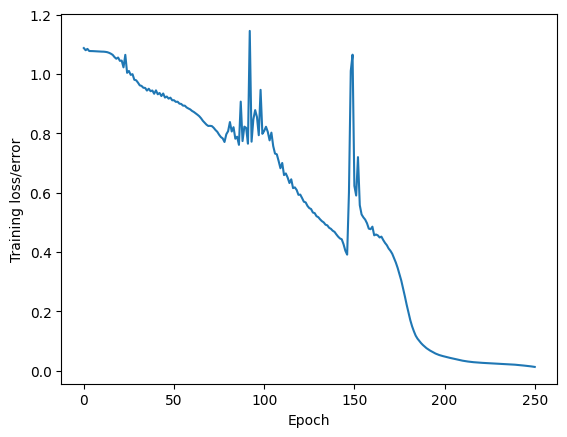

In [21]:
plt.plot(range(len(losses)), losses)
plt.ylabel("Training loss/error")
plt.xlabel('Epoch')
plt.savefig('training_loss.png')

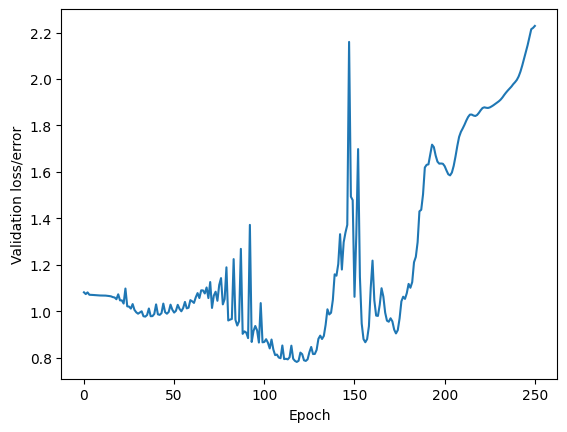

In [22]:
plt.plot(range(len(validation_losses)), validation_losses)
plt.ylabel("Validation loss/error")
plt.xlabel('Epoch')



plt.savefig('validation_loss.png')




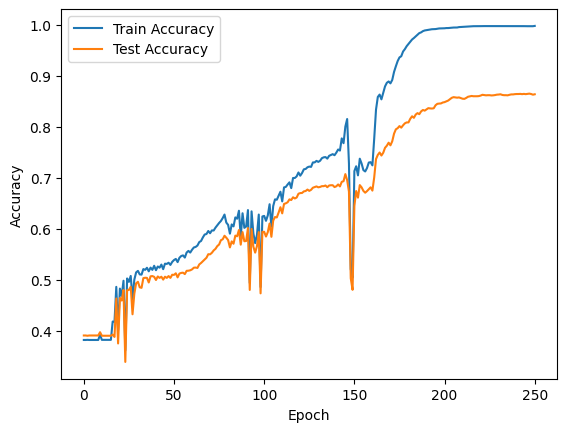

In [23]:
plt.plot(range(len(train_accuracy)), train_accuracy, label='Train Accuracy')
plt.plot(range(len(test_accuracy)), test_accuracy, label='Test Accuracy')
plt.ylabel("Accuracy")
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [24]:

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 2501
losses = []
validation_losses = []
test_accuracy = []
train_accuracy = []

# Move data to GPU
data_train = data_train.to(device)
label_train = label_train.to(device)
data_test = data_test.to(device)
label_test = label_test.to(device)

for i in range(epochs):
  
  y_pred = model.forward(data_train) 

  loss = criterion(y_pred, label_train).to("cpu") 
  train_accuracy.append(accuracy(y_pred.argmax(1), label_train))

  # Evaluate Model on Test Data Set (validate model on test set)
  with torch.no_grad():  # Basically turn off back propogation
    y_eval = model.forward(data_test) # X_test are features from our test set, y_eval will be predictions
    validation_loss = criterion(y_eval, label_test).to("cpu") # Find the loss or error
    validation_losses.append(validation_loss.detach().numpy().item())
    test_accuracy.append(accuracy(y_eval.argmax(1), label_test))


  losses.append(loss.detach().numpy().item())

  if i % 100 == 0:
    print(f'Epoch: {i} and train loss: {loss} | validation loss : {validation_loss}')
    acc= accuracy(y_eval.argmax(1), label_test)
    acc_train = accuracy(y_pred.argmax(1), label_train)
    print(f'Epoch: {i} Accuracy Train: {acc_train} | Accuracy Test: {acc}')

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

Epoch: 0 and train loss: 0.011377718299627304 | validation loss : 2.2392795085906982
Epoch: 0 Accuracy Train: 0.9975824175824176 | Accuracy Test: 0.8666666666666667
Epoch: 100 and train loss: 0.002977614989504218 | validation loss : 2.891752243041992
Epoch: 100 Accuracy Train: 0.9984615384615385 | Accuracy Test: 0.8605128205128205
Epoch: 200 and train loss: 0.0022825123742222786 | validation loss : 3.842848777770996
Epoch: 200 Accuracy Train: 0.9989010989010989 | Accuracy Test: 0.8630769230769231
Epoch: 300 and train loss: 0.002211739309132099 | validation loss : 4.363227367401123
Epoch: 300 Accuracy Train: 0.9989010989010989 | Accuracy Test: 0.8651282051282051
Epoch: 400 and train loss: 0.002205883851274848 | validation loss : 4.568902015686035
Epoch: 400 Accuracy Train: 0.9989010989010989 | Accuracy Test: 0.8669230769230769
Epoch: 500 and train loss: 0.0021559291053563356 | validation loss : 4.834160804748535
Epoch: 500 Accuracy Train: 0.9989010989010989 | Accuracy Test: 0.8653846153

Text(0.5, 0, 'Epoch')

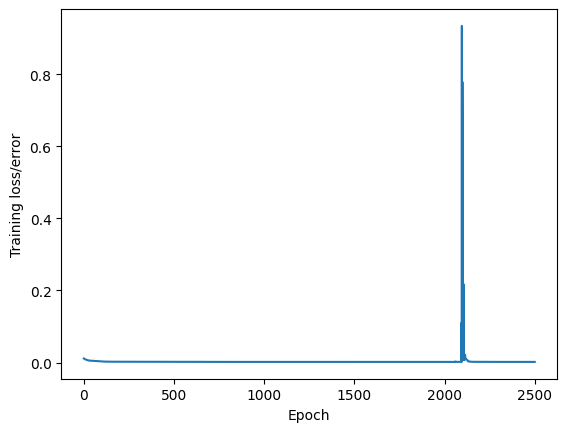

In [25]:
plt.plot(range(len(losses)), losses)
plt.ylabel("Training loss/error")
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

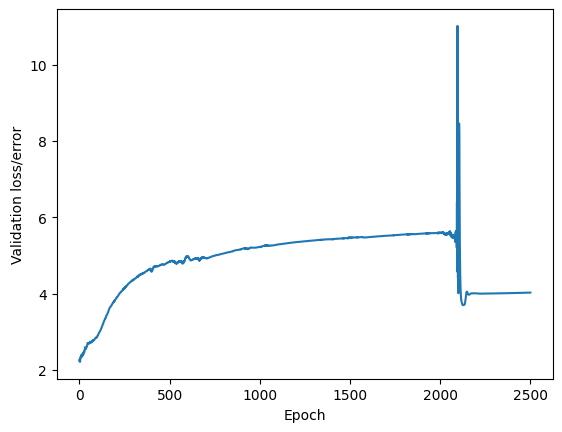

In [26]:
plt.plot(range(len(validation_losses)), validation_losses)
plt.ylabel("Validation loss/error")
plt.xlabel('Epoch')


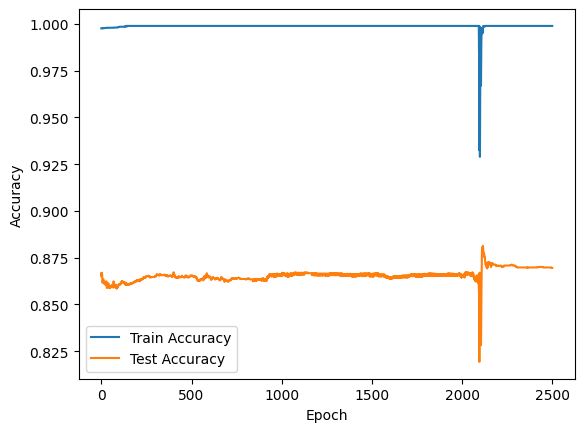

In [27]:
plt.plot(range(len(train_accuracy)), train_accuracy, label='Train Accuracy')
plt.plot(range(len(test_accuracy)), test_accuracy, label='Test Accuracy')
plt.ylabel("Accuracy")
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [28]:

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

epochs = 2501
losses = []
validation_losses = []
test_accuracy = []
train_accuracy = []

# Move data to GPU
data_train = data_train.to(device)
label_train = label_train.to(device)
data_test = data_test.to(device)
label_test = label_test.to(device)

for i in range(epochs):
  
  y_pred = model.forward(data_train) 

  loss = criterion(y_pred, label_train).to("cpu") 
  train_accuracy.append(accuracy(y_pred.argmax(1), label_train))

  # Evaluate Model on Test Data Set (validate model on test set)
  with torch.no_grad():  # Basically turn off back propogation
    y_eval = model.forward(data_test) # X_test are features from our test set, y_eval will be predictions
    validation_loss = criterion(y_eval, label_test).to("cpu") # Find the loss or error
    validation_losses.append(validation_loss.detach().numpy().item())
    test_accuracy.append(accuracy(y_eval.argmax(1), label_test))


  losses.append(loss.detach().numpy().item())

  if i % 25 == 0:
    print(f'Epoch: {i} and train loss: {loss} | validation loss : {validation_loss}')
    acc= accuracy(y_eval.argmax(1), label_test)
    acc_train = accuracy(y_pred.argmax(1), label_train)
    print(f'Epoch: {i} Accuracy Train: {acc_train} | Accuracy Test: {acc}')

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

Epoch: 0 and train loss: 0.0018494029063731432 | validation loss : 4.023672103881836
Epoch: 0 Accuracy Train: 0.9989010989010989 | Accuracy Test: 0.8694871794871795
Epoch: 25 and train loss: 0.0018271690933033824 | validation loss : 4.192872047424316
Epoch: 25 Accuracy Train: 0.9989010989010989 | Accuracy Test: 0.8728205128205129
Epoch: 50 and train loss: 0.0018219316843897104 | validation loss : 4.312398910522461
Epoch: 50 Accuracy Train: 0.9989010989010989 | Accuracy Test: 0.8733333333333333
Epoch: 75 and train loss: 0.001819571596570313 | validation loss : 4.382401943206787
Epoch: 75 Accuracy Train: 0.9989010989010989 | Accuracy Test: 0.8743589743589744
Epoch: 100 and train loss: 0.001818087068386376 | validation loss : 4.421910285949707
Epoch: 100 Accuracy Train: 0.9989010989010989 | Accuracy Test: 0.8743589743589744
Epoch: 125 and train loss: 0.0018170641269534826 | validation loss : 4.453749179840088
Epoch: 125 Accuracy Train: 0.9989010989010989 | Accuracy Test: 0.874358974358974

Text(0.5, 0, 'Epoch')

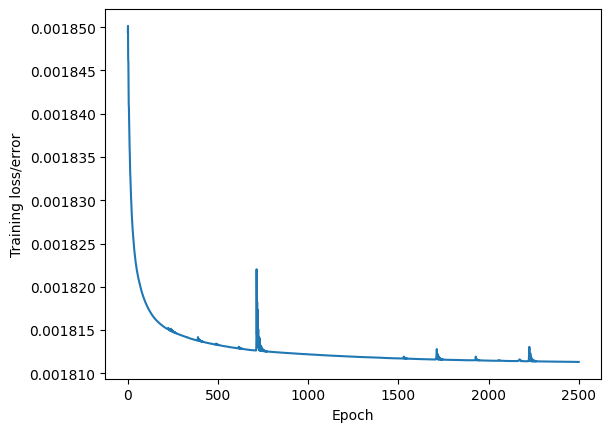

In [29]:
plt.plot(range(len(losses)), losses)
plt.ylabel("Training loss/error")
plt.xlabel('Epoch')


Text(0.5, 0, 'Epoch')

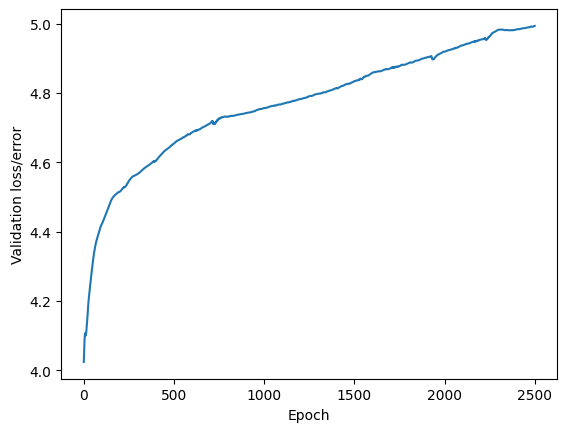

In [30]:
plt.plot(range(len(validation_losses)), validation_losses)
plt.ylabel("Validation loss/error")
plt.xlabel('Epoch')

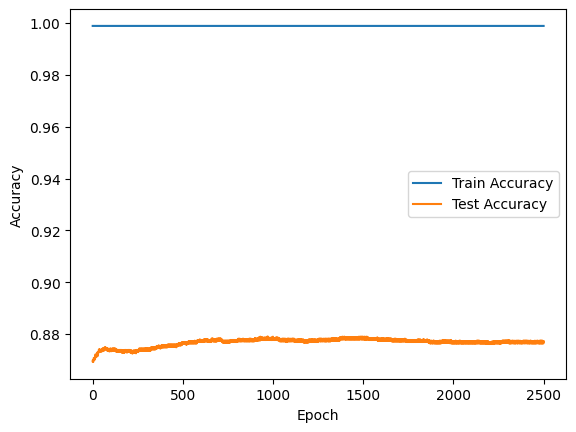

In [31]:
plt.plot(range(len(train_accuracy)), train_accuracy, label='Train Accuracy')
plt.plot(range(len(test_accuracy)), test_accuracy, label='Test Accuracy')
plt.ylabel("Accuracy")
plt.xlabel('Epoch')
plt.legend()
